Dataset 1 - Training Accuracy:  100.0
Dataset 1 - Validation Accuracy:  100.0
Dataset 1 - Test Accuracy:  100.0


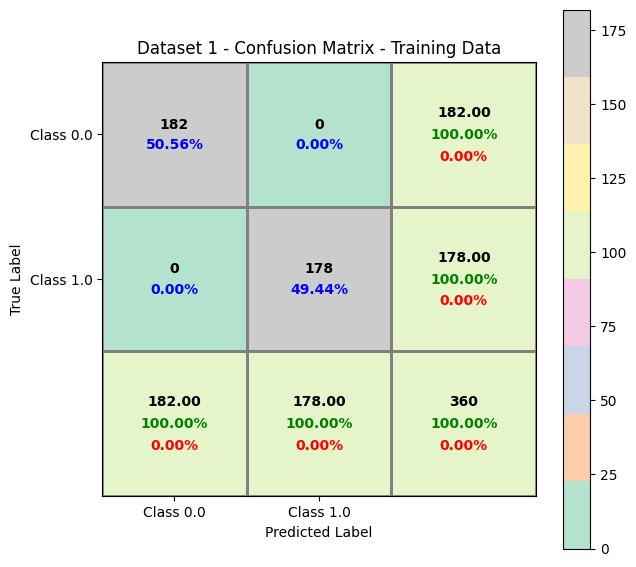

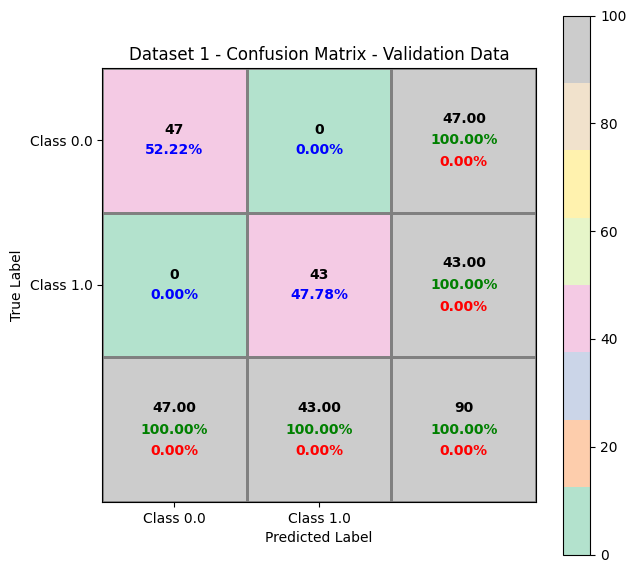

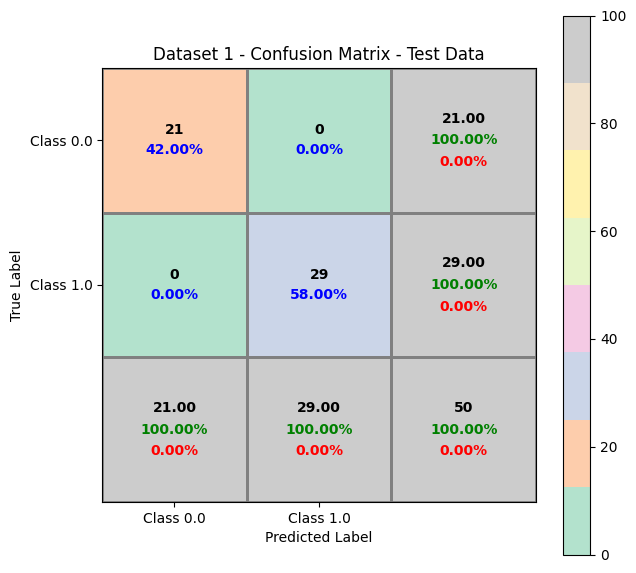

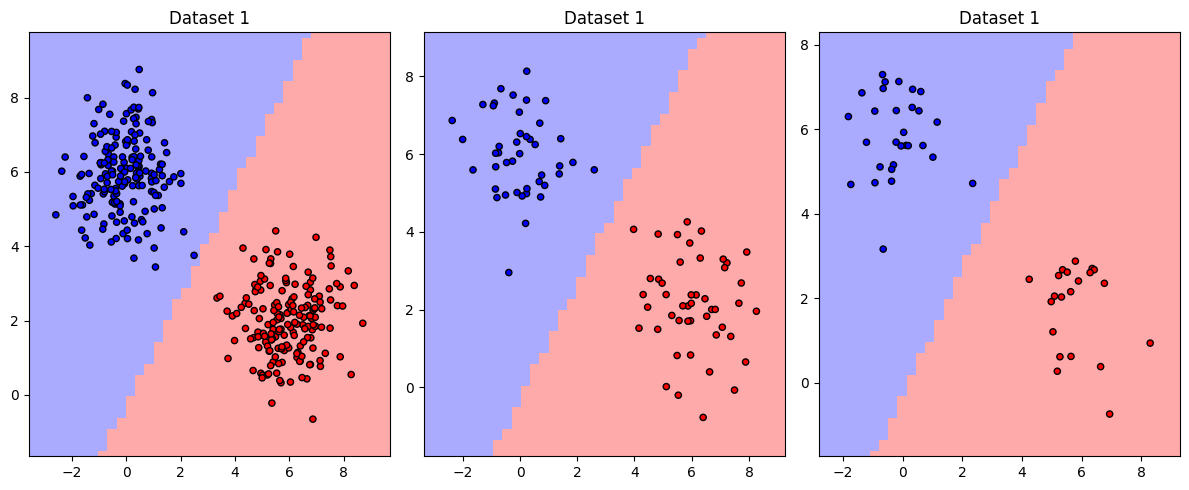

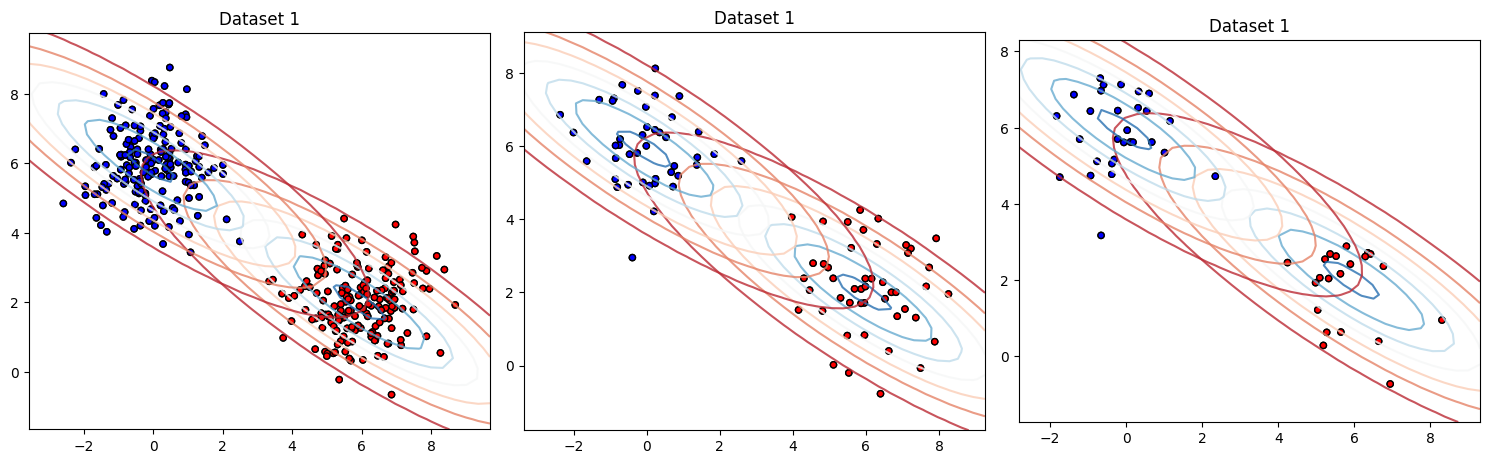

Dataset 2 - Training Accuracy:  71.73396674584322
Dataset 2 - Validation Accuracy:  73.10924369747899
Dataset 2 - Test Accuracy:  70.0


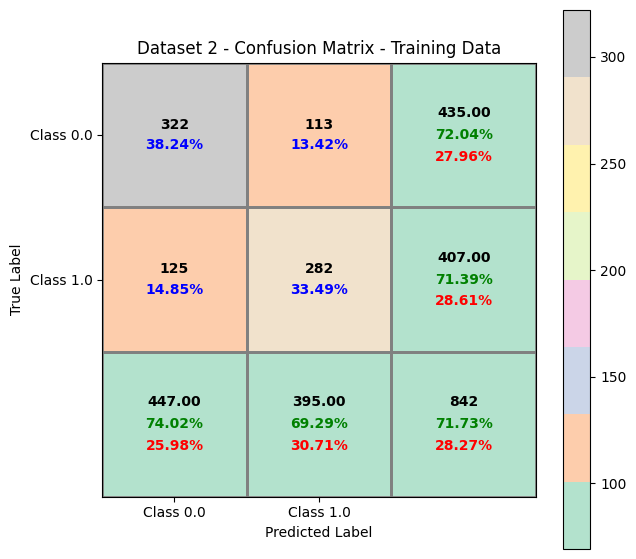

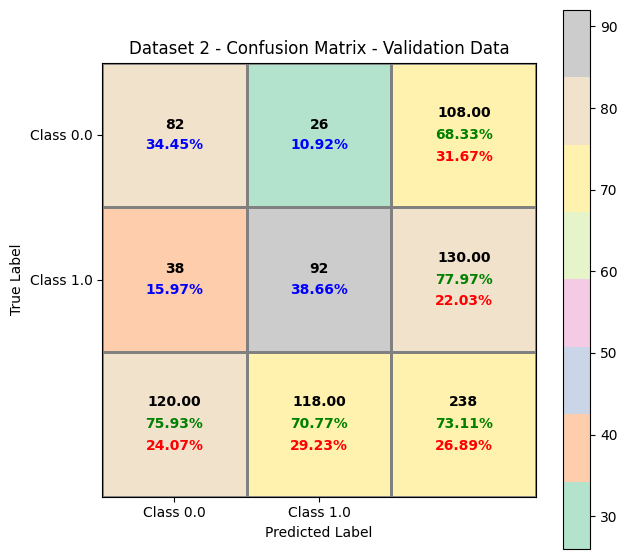

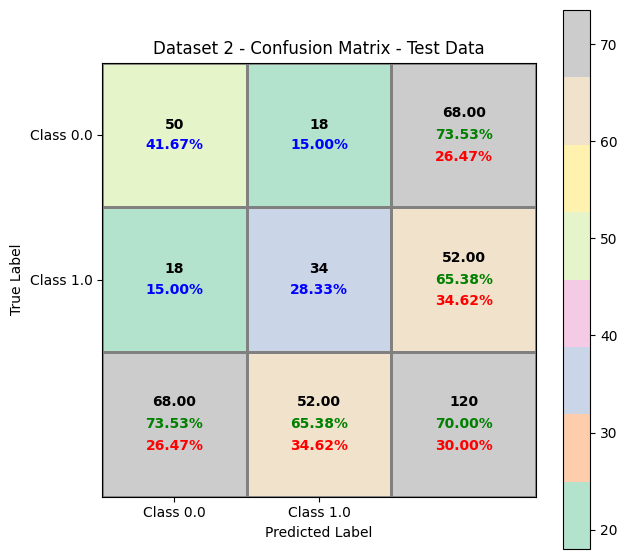

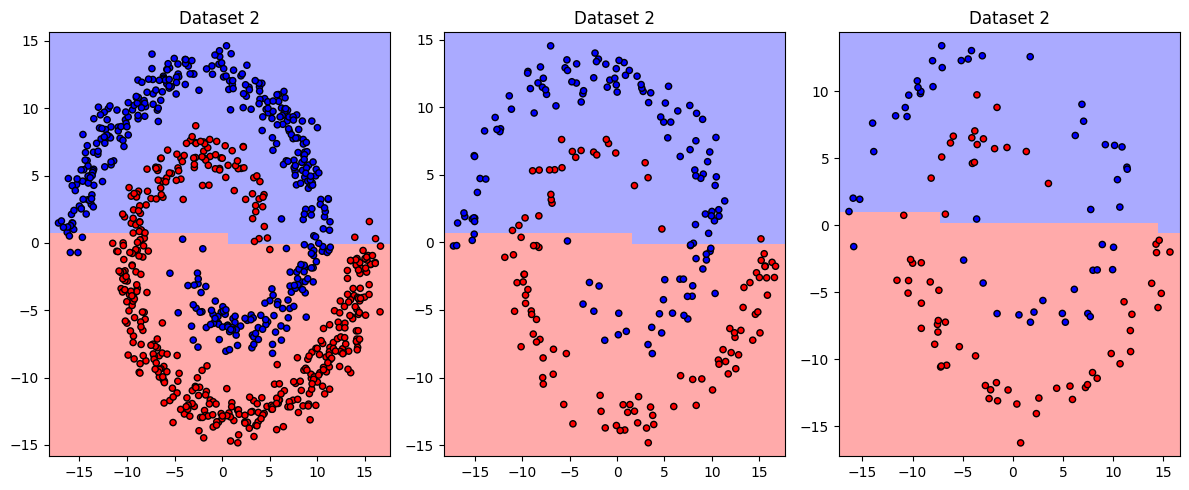

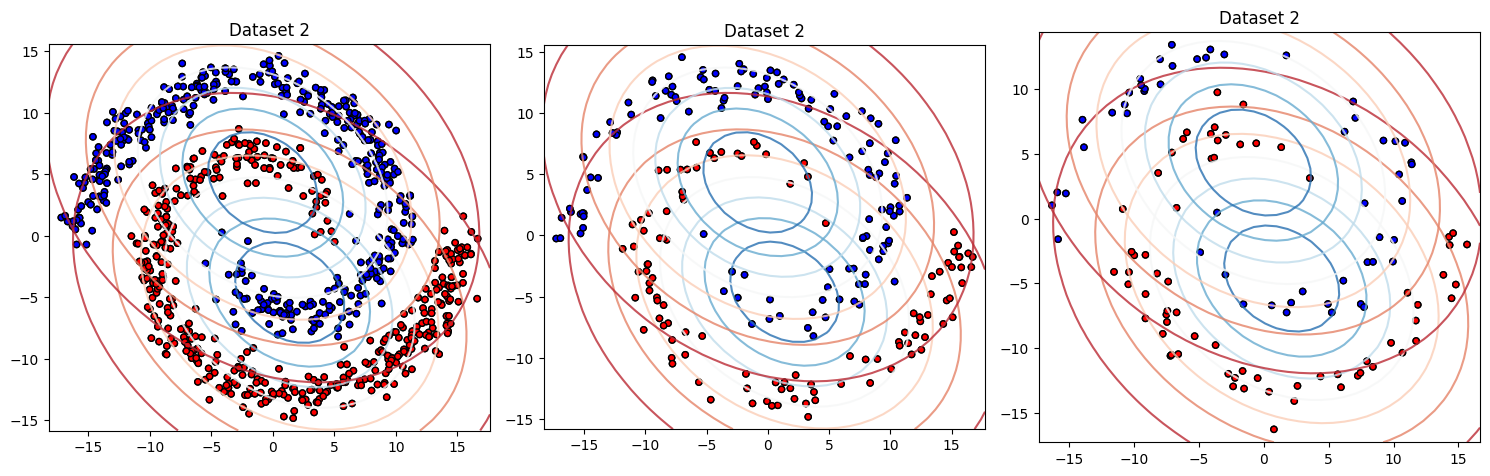

Dataset 3 - Training Accuracy:  68.64818519577021
Dataset 3 - Validation Accuracy:  65.16516516516516
Dataset 3 - Test Accuracy:  62.124248496993985


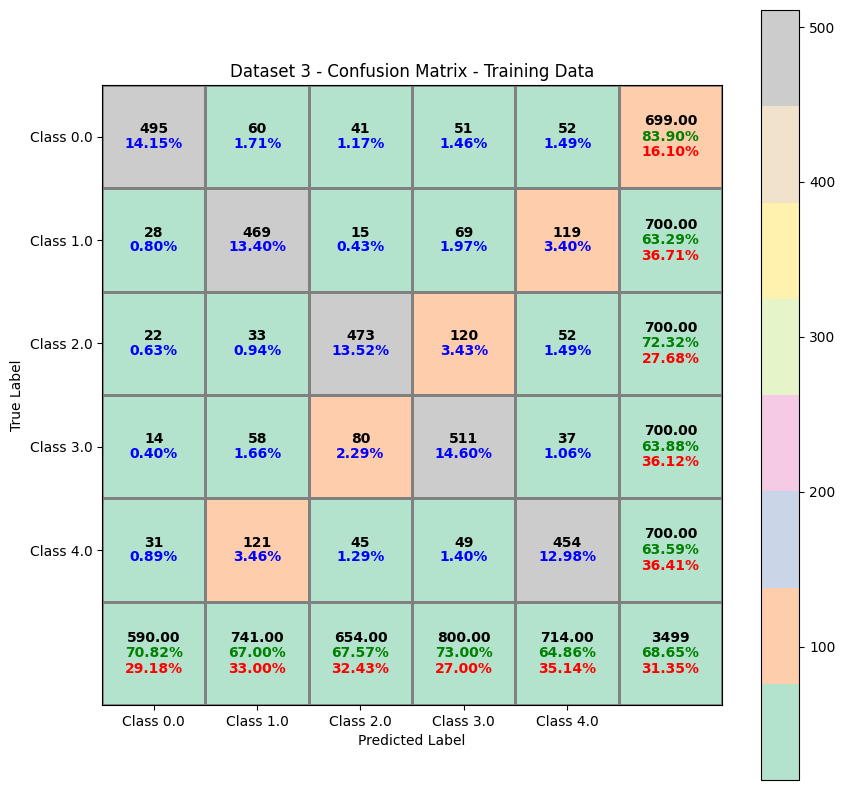

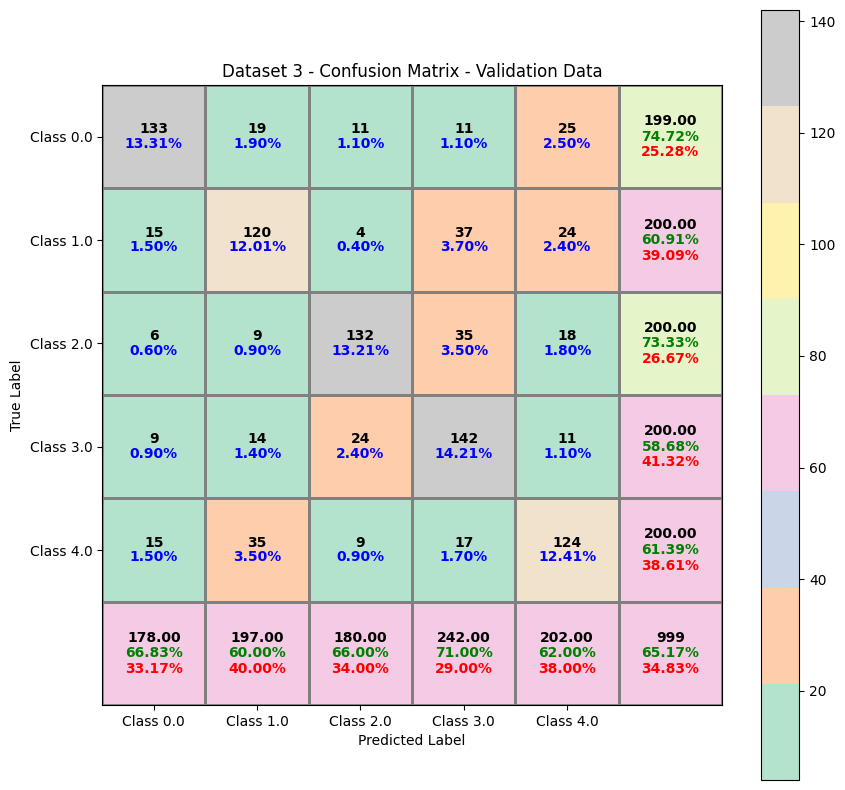

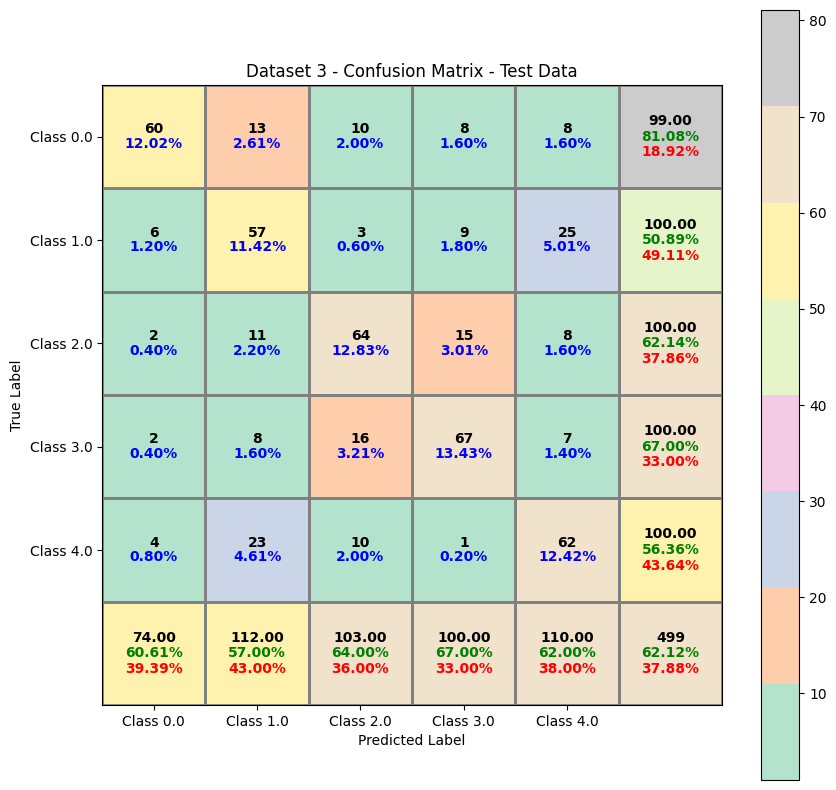

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class BayesianClassifier:

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        class_counts = []
        for cls in self.classes:
            count = np.sum(y_train == cls)
            class_counts.append(count)
        total_samples = len(y_train)
        self.class_priors = np.array(class_counts) / total_samples
        class_data = []
        for cls in self.classes:
            data = X_train[y_train == cls]
            class_data.append(data)

        self.class_means = []
        for class_ in class_data:
            mean_vector = np.mean(class_, axis=0)
            self.class_means.append(mean_vector)

        self.class_cov = np.cov(X_train.T)
        self.class_covs = []
        for class_ in class_data:
            self.class_covs.append(self.class_cov)

    def predict(self, X_test):
        likelihoods = []
        for class_mean, class_cov in zip(self.class_means, self.class_covs):
            likelihood = self.calculate_likelihood(X_test, class_mean, class_cov)
            likelihoods.append(likelihood)
        likelihoods = np.array(likelihoods)

        evidence = np.zeros(X_test.shape[0])
        for i in range(len(self.classes)):
            evidence += likelihoods[i] * self.class_priors[i]
        posteriors = likelihoods * self.class_priors[:, np.newaxis] / evidence
        # print("posteriors",posteriors)
        # print("np.argmax(posteriors, axis=0)",np.argmax(posteriors, axis=0))
        return np.argmax(posteriors, axis=0)
    
    def calculate_likelihood(self, X, class_mean, class_cov):
        d = X.shape[1]
        constant = 1 / ((2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(class_cov)))
        mean_diff = X - class_mean
        exponent = -0.5 * np.sum(np.dot(mean_diff, np.linalg.inv(class_cov)) * mean_diff, axis=1)
        return constant * np.exp(exponent)


def custom_unique(input_array):
    unique_list = []
    for item in input_array:
        if item not in unique_list:
            unique_list.append(item)
    return np.array(unique_list)

def custom_mean(input_array):
    return sum(input_array) / len(input_array)

def custom_covariance_matrix(X):
    mean_vector = custom_mean(X)
    centered_data = X - mean_vector
    covariance_matrix = np.dot(centered_data.T, centered_data) / (X.shape[0] - 1)
    return covariance_matrix

def custom_std(feature):
    mean = np.mean(feature)
    squared_diff = np.square(feature - mean)
    variance = np.mean(squared_diff)
    std = np.sqrt(variance)
    return std

def accuracy_score(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Number of true labels and predicted labels must be the same.")
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total = len(y_true)
    accuracy = correct / total
    return accuracy

def confusion_matrix(y_true, y_pred, accuracy, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels + 1, num_labels + 1), float)
    label_to_index = {label: i for i, label in enumerate(labels)}
    true_positives = np.zeros(num_labels)
    pred_positives = np.zeros(num_labels)
    total_samples = len(y_true)
    for true, pred in zip(y_true, y_pred):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
        true_positives[true_index] += 1 if true == pred else 0
        pred_positives[pred_index] += 1 if true == pred else 0
    accuracy = np.sum(np.diag(cm)) / total_samples
    cm[-1, :-1] = (true_positives / np.sum(cm[:-1, :-1], axis=1))*100
    cm[:-1, -1] = (pred_positives / np.sum(cm[:-1, :-1], axis=0))*100
    cm[-1, -1] = accuracy*100
    return cm

def plot_confusion_matrix(y_true, y_pred, accuracy, title):
    cm = confusion_matrix(y_true, y_pred, accuracy)
    number_of_classes = len(np.unique(y_true))
    plt.figure(figsize=(number_of_classes+5, number_of_classes+5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel2)
    plt.title(title)
    plt.colorbar()
    labels = []
    for i in np.unique(y_true):
        label = "Class "+ str(i)
        labels.append(label)
    plt.xticks(range(len(np.unique(y_true))), labels=labels)
    plt.yticks(range(len(np.unique(y_true))), labels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    cm_except_last_row_col = cm[:-1, :-1]
    cm_row_sum = np.sum(cm_except_last_row_col, axis=1)
    cm_col_sum = np.sum(cm_except_last_row_col, axis=0)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        row_sum = 0
        for j in range(cm.shape[1]):
            if i == cm.shape[0]-1 and j==cm.shape[1]-1:
                plt.text(j, i-0.15, format(y_true.size, 'd'),
                     ha="center", va="center", fontweight='bold',
                    color="black")
                plt.text(j, i, format(cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="green")
                plt.text(j, i+0.15, format(100-cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="red")
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='grey', linewidth=2)
                plt.gca().add_patch(rect)
            elif j==cm.shape[1]-1:
                plt.text(j, i-0.15, format(cm_row_sum[i], '.2f'),
                     ha="center", va="center", fontweight='bold',
                    color="black")
                plt.text(j, i, format(cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="green")
                plt.text(j, i+0.15, format(100-cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="red")
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='grey', linewidth=2)
                plt.gca().add_patch(rect)
            elif i==cm.shape[0]-1:
                plt.text(j, i-0.15, format(cm_col_sum[j], '.2f'),
                     ha="center", va="center", fontweight='bold',
                    color="black")
                plt.text(j, i, format(cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="green")
                plt.text(j, i+0.15, format(100-cm[i, j], '.2f')+"%",
                     ha="center", va="center", fontweight='bold',
                    color="red")
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='grey', linewidth=2)
                plt.gca().add_patch(rect)
            else:
                percent = (cm[i, j]/y_true.size)*100
                plt.text(j, i-0.07, format(int(cm[i, j]), 'd'),
                         ha="center", va="center", fontweight='bold',
                        color="black")
                plt.text(j, i+0.07, format(percent,'.2f')+"%",
                         ha="center", va="center", fontweight='bold',
                        color="blue")
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='grey', linewidth=2)
                plt.gca().add_patch(rect)

    plt.grid(False)
    plt.show()

def plot_decision_boundary(X, y, classifier, ax, title):
    N = 40

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_range = np.linspace(x_min, x_max, N)
    y_range = np.linspace(y_min, y_max, N)
    xx, yy = np.meshgrid(x_range, y_range)

    Z_list = []

    for point in np.c_[xx.ravel(), yy.ravel()]:
        prediction = classifier.predict(np.array([point]))
        Z_list.append(prediction)

    Z = np.array(Z_list)

    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=ListedColormap(["#FF0000", "#00FF00", "#0000FF"]),
        edgecolors="k",
        s=20,
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

def plot_level_curve(X, y, classifier, ax, title):
    N = 40

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_range = np.linspace(x_min, x_max, N)
    y_range = np.linspace(y_min, y_max, N)
    xx, yy = np.meshgrid(x_range, y_range)

    pos = np.dstack((xx, yy))

    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])

    means = classifier.class_means
    covs = classifier.class_covs
    ax.set_aspect("equal")
    for mean, cov in zip(means, covs):
        Z = np.exp(-0.5 * np.sum((pos - mean) @ np.linalg.inv(cov) * (pos - mean), axis=2)) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
        
        ax.contour(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
        ax.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["#FF0000", "#00FF00", "#0000FF"]),
            edgecolors="k",
            s=20,
        )
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title(title)


def read_dataset_1(current_directory, folder_number):
    # regression_dataset_1_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 1/" + folder_number + "/"
    regression_dataset_1_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 1/"
        + folder_number
        + "/"
    )

    regression_dataset_1_Train = (
        regression_dataset_1_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_1_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    regression_dataset_1_Validation = (
        regression_dataset_1_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_1_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    regression_dataset_1_Test = (
        regression_dataset_1_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_1_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y



def read_dataset_2(current_directory, folder_number):
    # regression_dataset_2_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 2/" + folder_number + "/"
    regression_dataset_2_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 2/"
        + folder_number
        + "/"
    )
    
    regression_dataset_2_Train = (
        regression_dataset_2_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    regression_dataset_2_Validation = (
        regression_dataset_2_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    regression_dataset_2_Test = (
        regression_dataset_2_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y


def read_dataset_3(current_directory, folder_number):
    # regression_dataset_2_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 3/" + folder_number + "/"
    regression_dataset_3_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass1/Datasets_for_A1/Classification/Dataset 3/"
        + folder_number
        + "/"
    )

    regression_dataset_3_Train_data = regression_dataset_3_path + "train_data.csv"
    df = pd.read_csv(regression_dataset_3_Train_data)
    data = df.to_numpy()
    train_x = data

    regression_dataset_3_Train_label = regression_dataset_3_path + "train_label.csv"
    df = pd.read_csv(regression_dataset_3_Train_label)
    data = df.to_numpy()
    train_y = data[:, 0]

    regression_dataset_3_Validation_data = regression_dataset_3_path + "val_data.csv"
    df = pd.read_csv(regression_dataset_3_Validation_data)
    data = df.to_numpy()
    val_x = data

    regression_dataset_3_Validation_label = regression_dataset_3_path + "val_label.csv"
    df = pd.read_csv(regression_dataset_3_Validation_label)
    data = df.to_numpy()
    val_y = data[:, 0]

    regression_dataset_3_Test_data = regression_dataset_3_path + "test_data.csv"
    df = pd.read_csv(regression_dataset_3_Test_data)
    data = df.to_numpy()
    test_x = data

    regression_dataset_3_Test_label = regression_dataset_3_path + "test_label.csv"
    df = pd.read_csv(regression_dataset_3_Test_label)
    data = df.to_numpy()
    test_y = data[:, 0]

    return train_x, train_y, val_x, val_y, test_x, test_y

def generate_random_data():
    # Generate synthetic data
    np.random.seed(0)
    X_train = np.random.randn(300, 2)
    y_train = np.concatenate([np.zeros(150), np.ones(150)])

    X_val = np.random.randn(100, 2)
    y_val = np.concatenate([np.zeros(50), np.ones(50)])

    X_test = np.random.randn(100, 2)
    y_test = np.concatenate([np.zeros(50), np.ones(50)])

    return X_train, y_train, X_val, y_val, X_test, y_test


def apply_bayes_classifier_same_cov(train_x, train_y, val_x, val_y, test_x, test_y, dataset):
    classifier = BayesianClassifier()
    classifier.fit(train_x, train_y)

    train_y_pred = classifier.predict(train_x)
    val_y_pred = classifier.predict(val_x)
    test_y_pred = classifier.predict(test_x)

    train_accuracy = accuracy_score(train_y, train_y_pred)*100
    val_accuracy = accuracy_score(val_y, val_y_pred)*100
    test_accuracy = accuracy_score(test_y, test_y_pred)*100

    print(dataset,"- Training Accuracy: ", train_accuracy)
    print(dataset,"- Validation Accuracy: ", val_accuracy)
    print(dataset,"- Test Accuracy: ", test_accuracy)


    plot_confusion_matrix(train_y, train_y_pred, train_accuracy, title=dataset+" - Confusion Matrix - Training Data")
    plot_confusion_matrix(val_y, val_y_pred, val_accuracy, title=dataset+" - Confusion Matrix - Validation Data")
    plot_confusion_matrix(test_y, test_y_pred, test_accuracy, title=dataset+" - Confusion Matrix - Test Data")

    if(dataset != "Dataset 3"):
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))
        plot_decision_boundary(train_x, train_y, classifier, axes[0], dataset)
        plot_decision_boundary(val_x, val_y, classifier, axes[1], dataset)
        plot_decision_boundary(test_x, test_y, classifier, axes[2], dataset)
        plt.tight_layout()
        plt.show()
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
        plot_level_curve(train_x, train_y, classifier, axes[0], dataset)
        plot_level_curve(val_x, val_y, classifier, axes[1], dataset)
        plot_level_curve(test_x, test_y, classifier, axes[2], dataset)
        plt.tight_layout()
        plt.show()

def main():
    # train_x, train_y, val_x, val_y, test_x, test_y = generate_random_data()

    folder_number = "9"
    current_directory = os.getcwd()

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_1(
        current_directory, folder_number
    )
    apply_bayes_classifier_same_cov(train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 1")

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_2(
        current_directory, folder_number
    )
    apply_bayes_classifier_same_cov(train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 2")

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_3(
        current_directory, folder_number
    )
    apply_bayes_classifier_same_cov(train_x, train_y, val_x, val_y, test_x, test_y, "Dataset 3")

if __name__ == "__main__":
    main()
